**References**

1. Dräger, S., & Sonnewald, M. (2024). *The Importance of Architecture Choice in Deep Learning for Climate Applications*. arXiv. [https://arxiv.org/abs/2402.13979](https://arxiv.org/abs/2402.13979)

2. Tziperman, E. (2022). Climate feedbacks and their importance. In *Global Warming Science* (pp. 123-145). Princeton University Press.

3. Tziperman, E. (2022). Code associated with *Global Warming Science*. Accompanying material provided with the textbook.


In [40]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

In [2]:
# set parameters
meter=1;
year=365*24*3600;
S0=35.0;
T0=24.0
DeltaT=-10;
time_max=150000*year;
alpha=0.2; # (kg/m^3) K^-1
beta=0.8; # (kg/m^3) ppt^-1
k=10e9 # (m^3/s)/(kg/m^3) #  3e-8; # sec^-1
# area of each of the ocean boxes, rediculous value, needed to get
# all other results at the right order of magnitude:
area=(50000.0e3)**2
depth=4000
V=area*depth # volume of each of the ocean boxes
Sv=1.e9 # m^3/sec

In [3]:
def q(DeltaT,DeltaS):
    flow= -k*(-alpha*DeltaT + beta*DeltaS)
    return flow

def Fs_func(time, time_max, forcing_func_type):
    Fs_min=-10
    Fs_max=10
    if forcing_func_type == "linear":
        flux=Fs_min+(Fs_max-Fs_min)*time/time_max
    elif forcing_func_type == "sine":
        flux=(Fs_max-Fs_min)*np.sin(6*np.pi*time/time_max)
        
    return flux*area*S0/year

def Ft_func(time, time_max, forcing_func_type):
    Ft_min = -8
    Ft_max = 8
    if forcing_func_type == "linear":
        flux = Ft_min+(Ft_max-Ft_min)*time/time_max;
    elif forcing_func_type == "sine":
        flux=(Ft_max-Ft_min)*np.sin(6*np.pi*time/time_max)
    return flux*area*T0/year

Fs_to_m_per_year=S0*area/year

Ft_to_m_per_year=T0*area/year

In [23]:
teval=np.arange(0, time_max, time_max/100000)
tspan=(teval[0], teval[-1])

In [24]:
# differential equation for change in salinity
def DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    dDeltaSdt = 2*np.abs(q(DeltaT, DeltaS))*DeltaS + 2*Fs_func(time, time_max, forcing_func_type)
    return -dDeltaSdt/V

In [25]:
# differential equation for change in temperature 
def DeltaT_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    dDeltaTdt = 2*np.abs(q(DeltaT, DeltaS))*DeltaT + 2*Ft_func(time, time_max, forcing_func_type)
    return -dDeltaTdt/V

In [26]:
# stommel model system (could combine the top 2 boxes into this function)
def system_de(DeltaS, DeltaT, time, time_max, forcing_func_type):
    return [DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type), DeltaT_de(DeltaS, DeltaT, time, time_max, forcing_func_type)]

In [27]:
# returns time, salinity_evolution
# time, salinity_evolution, temperature_evolution
def generate_data(forcing_func_type, include_temp):
    if include_temp:
        sol = solve_ivp(fun=lambda time, x: system_de(x[0], x[1], time, time_max, forcing_func_type) \
                ,vectorized=False,y0=[0.0, 0.0],t_span=tspan,t_eval=teval)
        return sol.t, sol.y[0], sol.y[1]
    else: 
        sol = solve_ivp(fun=lambda time, DeltaS: DeltaS_de(DeltaS, DeltaT, time, time_max, forcing_func_type) \
                ,vectorized=False,y0=[0.0],t_span=tspan,t_eval=teval)
        return sol.t, sol.y[0, :]

In [65]:
def generate_plots(forcing_func_type, include_temp, get_np_data=False):
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300) 
    ax[0].set_xlabel('t (time in kiloyears)');
    ax[1].set_xlabel('t (time in kiloyears)');
    ax[2].set_xlabel('t (time in kiloyears)');
    ax[0].set_title('Forcing');
    ax[1].set_title('Variables');
    ax[2].set_title('q (AMOC)');
    if include_temp:
        t, ys, yt = generate_data(forcing_func_type, include_temp)
        qplot, Fsplot, Ftplot = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
        i=0
        for tau in t:
            Fsplot[i]=Fs_func(tau, time_max, forcing_func_type)
            Ftplot[i]=Ft_func(tau, time_max, forcing_func_type)
            qplot[i]=q(yt[i], ys[i]);
            i=i+1
        ax[0].plot(t/year/1000, Fsplot, label='$F_s$');
        ax[0].plot(t/year/1000, Ftplot, label='$F_t$');
        ax[0].legend();
        ax[1].plot(t/year/1000, ys, label='$\Delta S$');
        ax[1].plot(t/year/1000, yt, label='$\Delta T$');
        ax[1].legend();
        ax[2].plot(t/year/1000, qplot);
        if get_np_data: 
            os.makedirs("data", exist_ok=True)
            input_data = np.zeros([100000, 5])
            output_data = np.zeros(len(input_data))
            for j in range(len(input_data)):
                input_data[j] = [t[j]/year/1000, ys[j], yt[j], Fsplot[j], Ftplot[j]]
                if qplot[j] < 0:
                    output_data[j] = 0
                else:
                    output_data[j] = 1
            np.save('data/' + 'input_sal_temp_' + forcing_func_type, input_data)
            np.save('data/' + 'output_sal_temp_' + forcing_func_type, output_data)
            np.save('data/' + 'q_sal_temp_' + forcing_func_type, qplot)
    else:
        t, ys = generate_data(forcing_func_type, include_temp)
        qplot, Fsplot, Ftplot = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
        i=0
        for tau in t:
            Fsplot[i]=Fs_func(tau, time_max, forcing_func_type)
            Ftplot[i]=Ft_func(tau, time_max, forcing_func_type)
            qplot[i]=q(DeltaT, ys[i]);
            i=i+1
        ax[0].plot(t/year/1000, Fsplot, label='$F_s$');
        ax[0].legend();
        ax[1].plot(t/year/1000, ys, label='$\Delta S$');
        ax[1].legend();
        ax[2].plot(t/year/1000, qplot);
        if get_np_data: 
            os.makedirs("data", exist_ok=True)
            input_data = np.zeros([100000, 4])
            output_data = np.zeros(len(input_data))
            for j in range(len(input_data)):
                input_data[j] = [t[j]/year/1000, ys[j], DeltaT, Fsplot[j]]
                if qplot[j] < 0:
                    output_data[j] = 0
                else:
                    output_data[j] = 1
            np.save('data/' + 'input_sal_' + forcing_func_type, input_data)
            np.save('data/' + 'output_sal_' + forcing_func_type, output_data)
            np.save('data/' + 'q_sal_' + forcing_func_type, qplot)
    
    return fig.tight_layout()

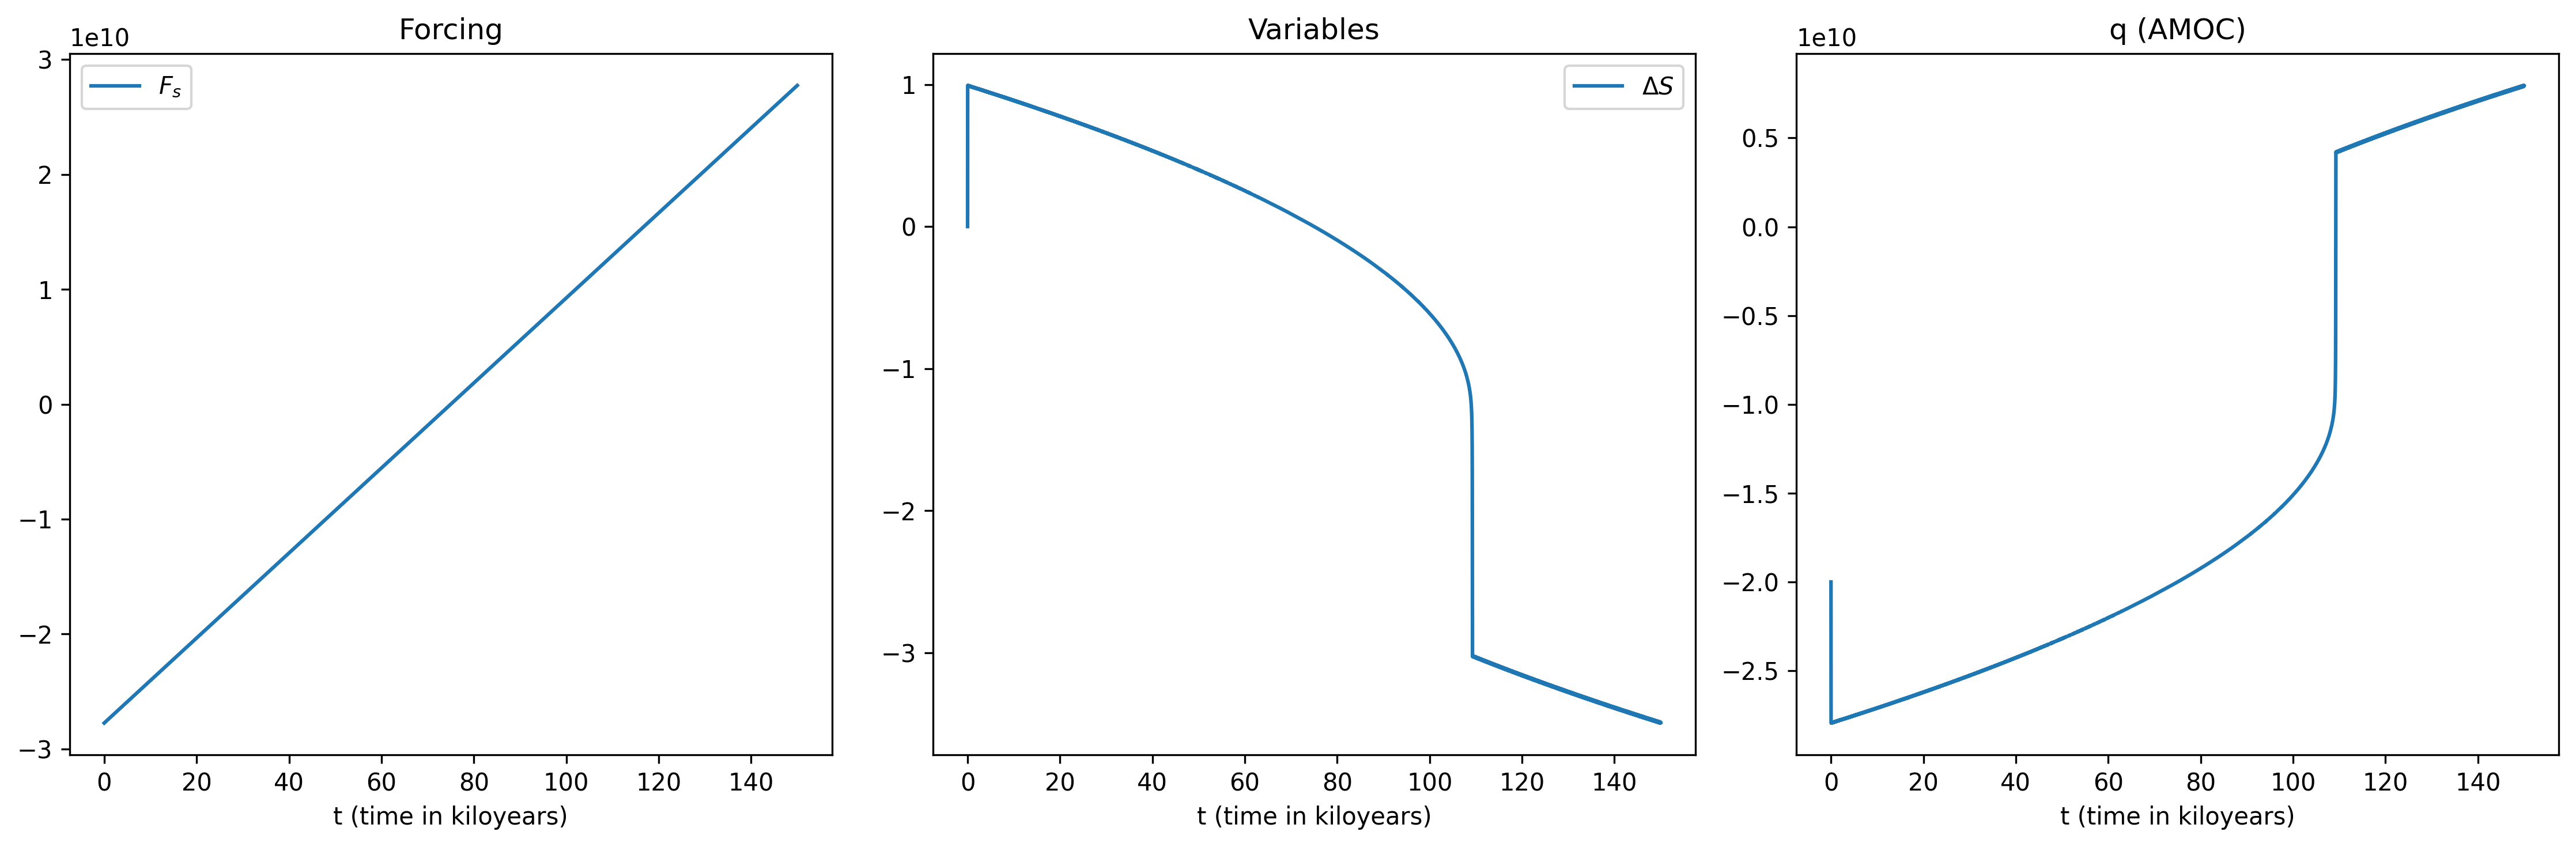

In [66]:
generate_plots("linear", False, True)

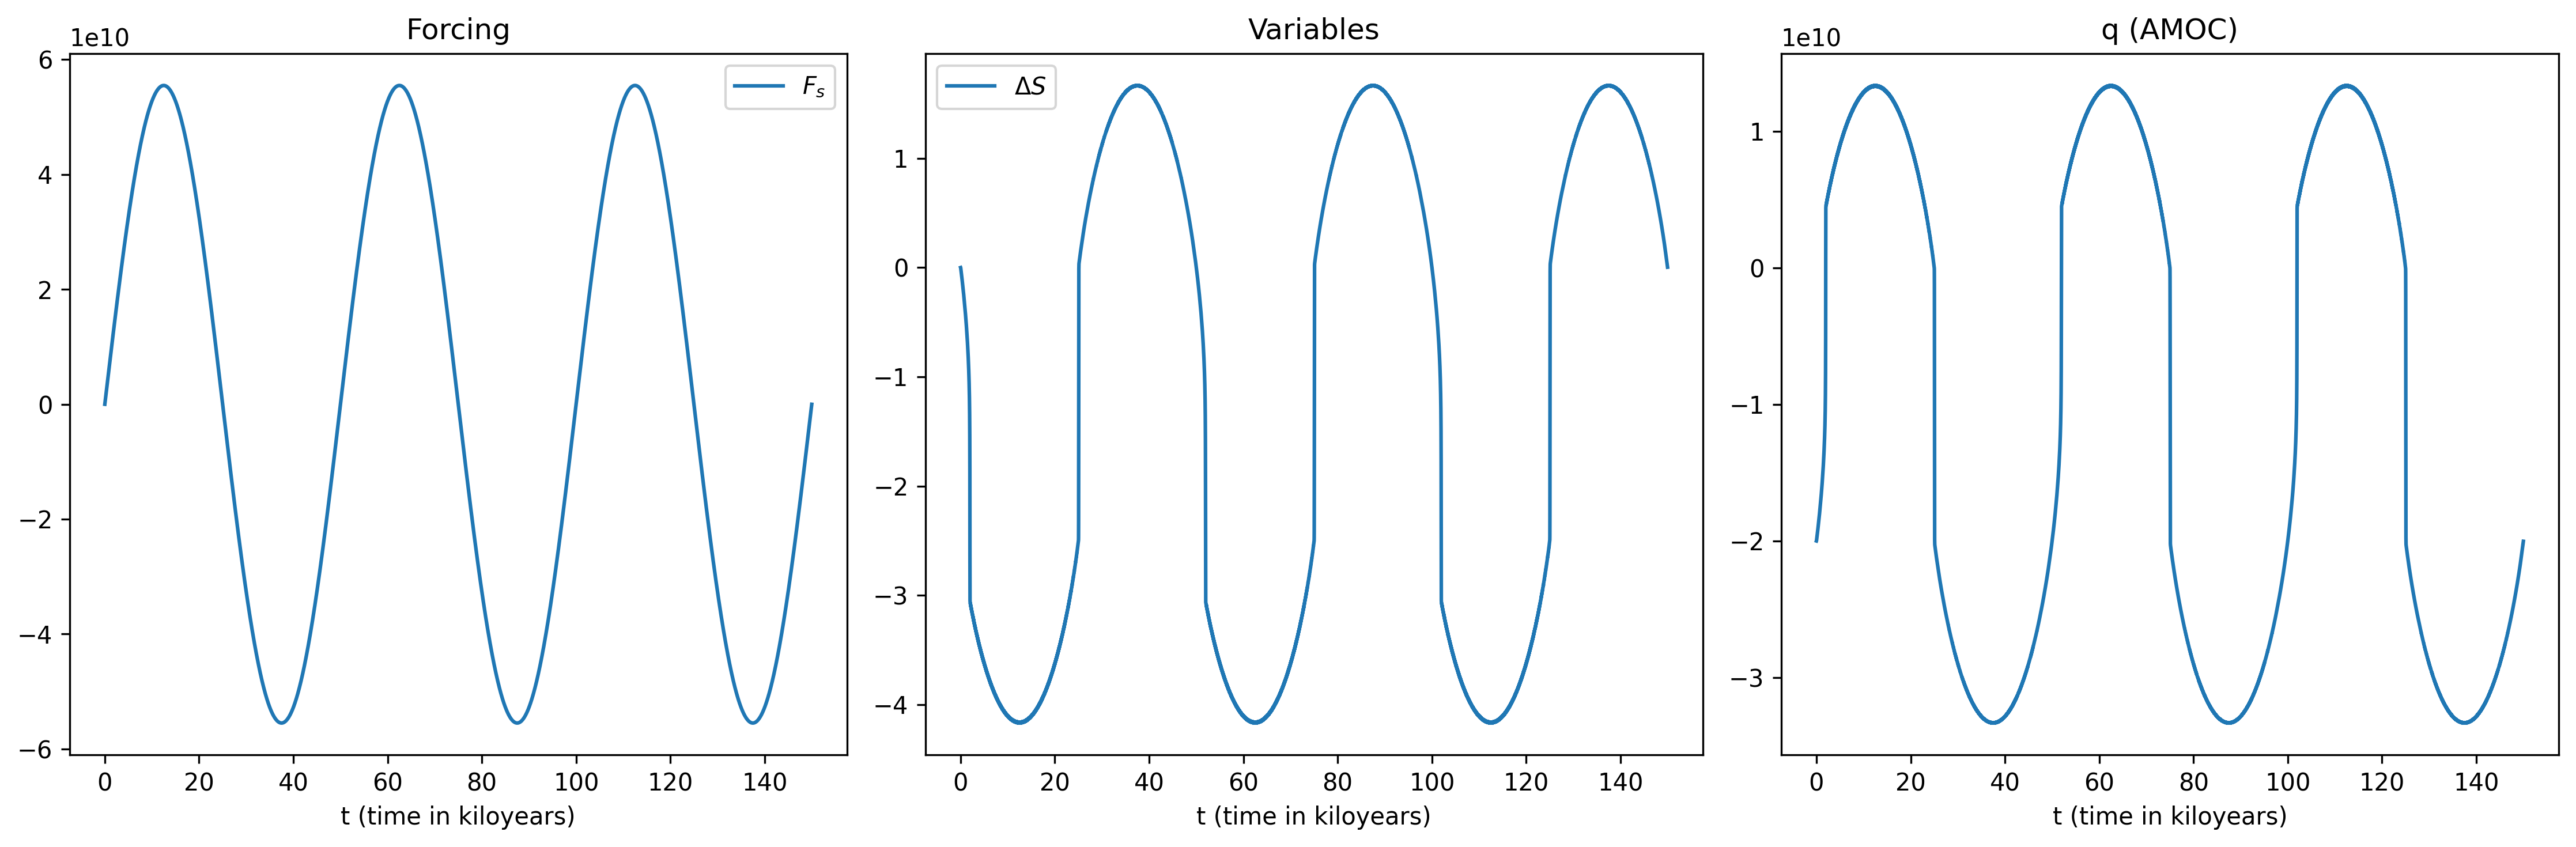

In [62]:
generate_plots("sine", False, True)

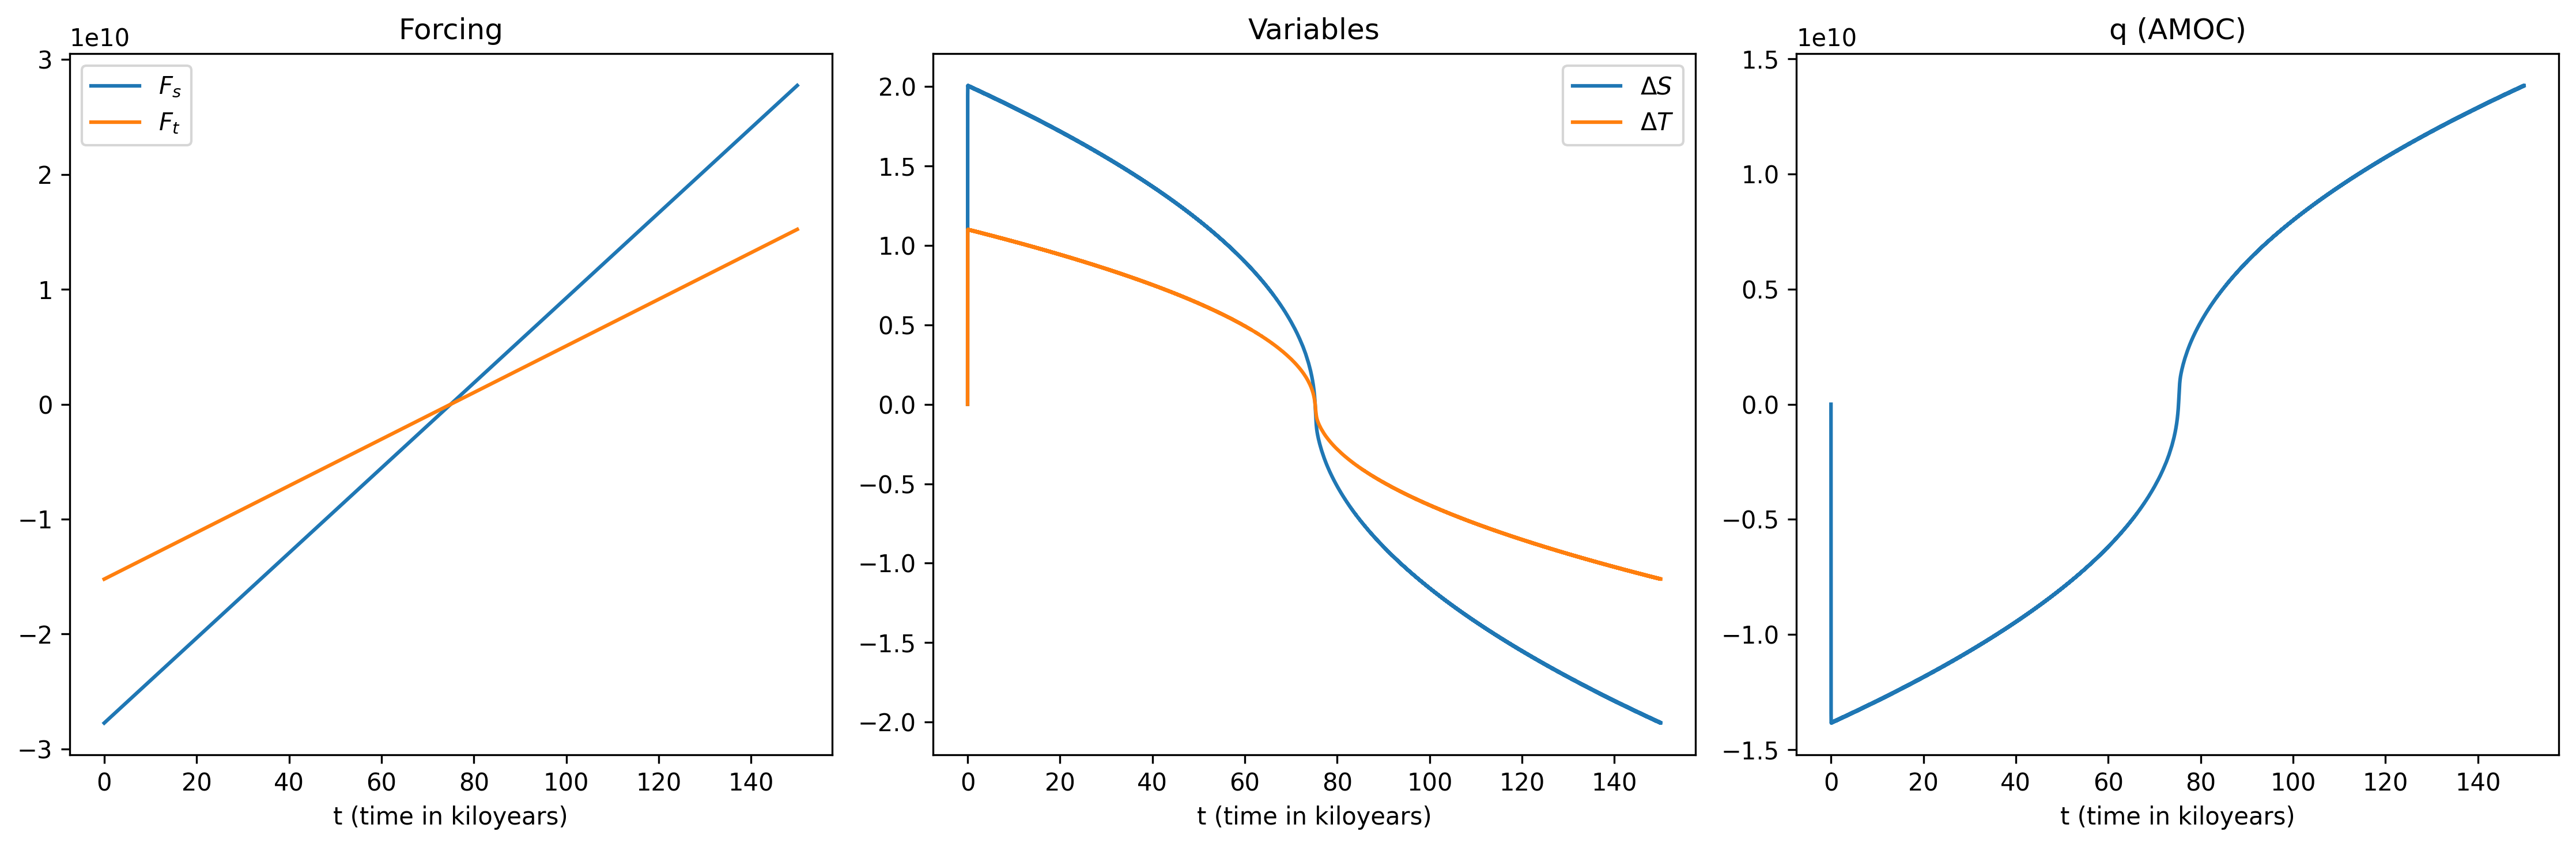

In [63]:
generate_plots("linear", True, True)

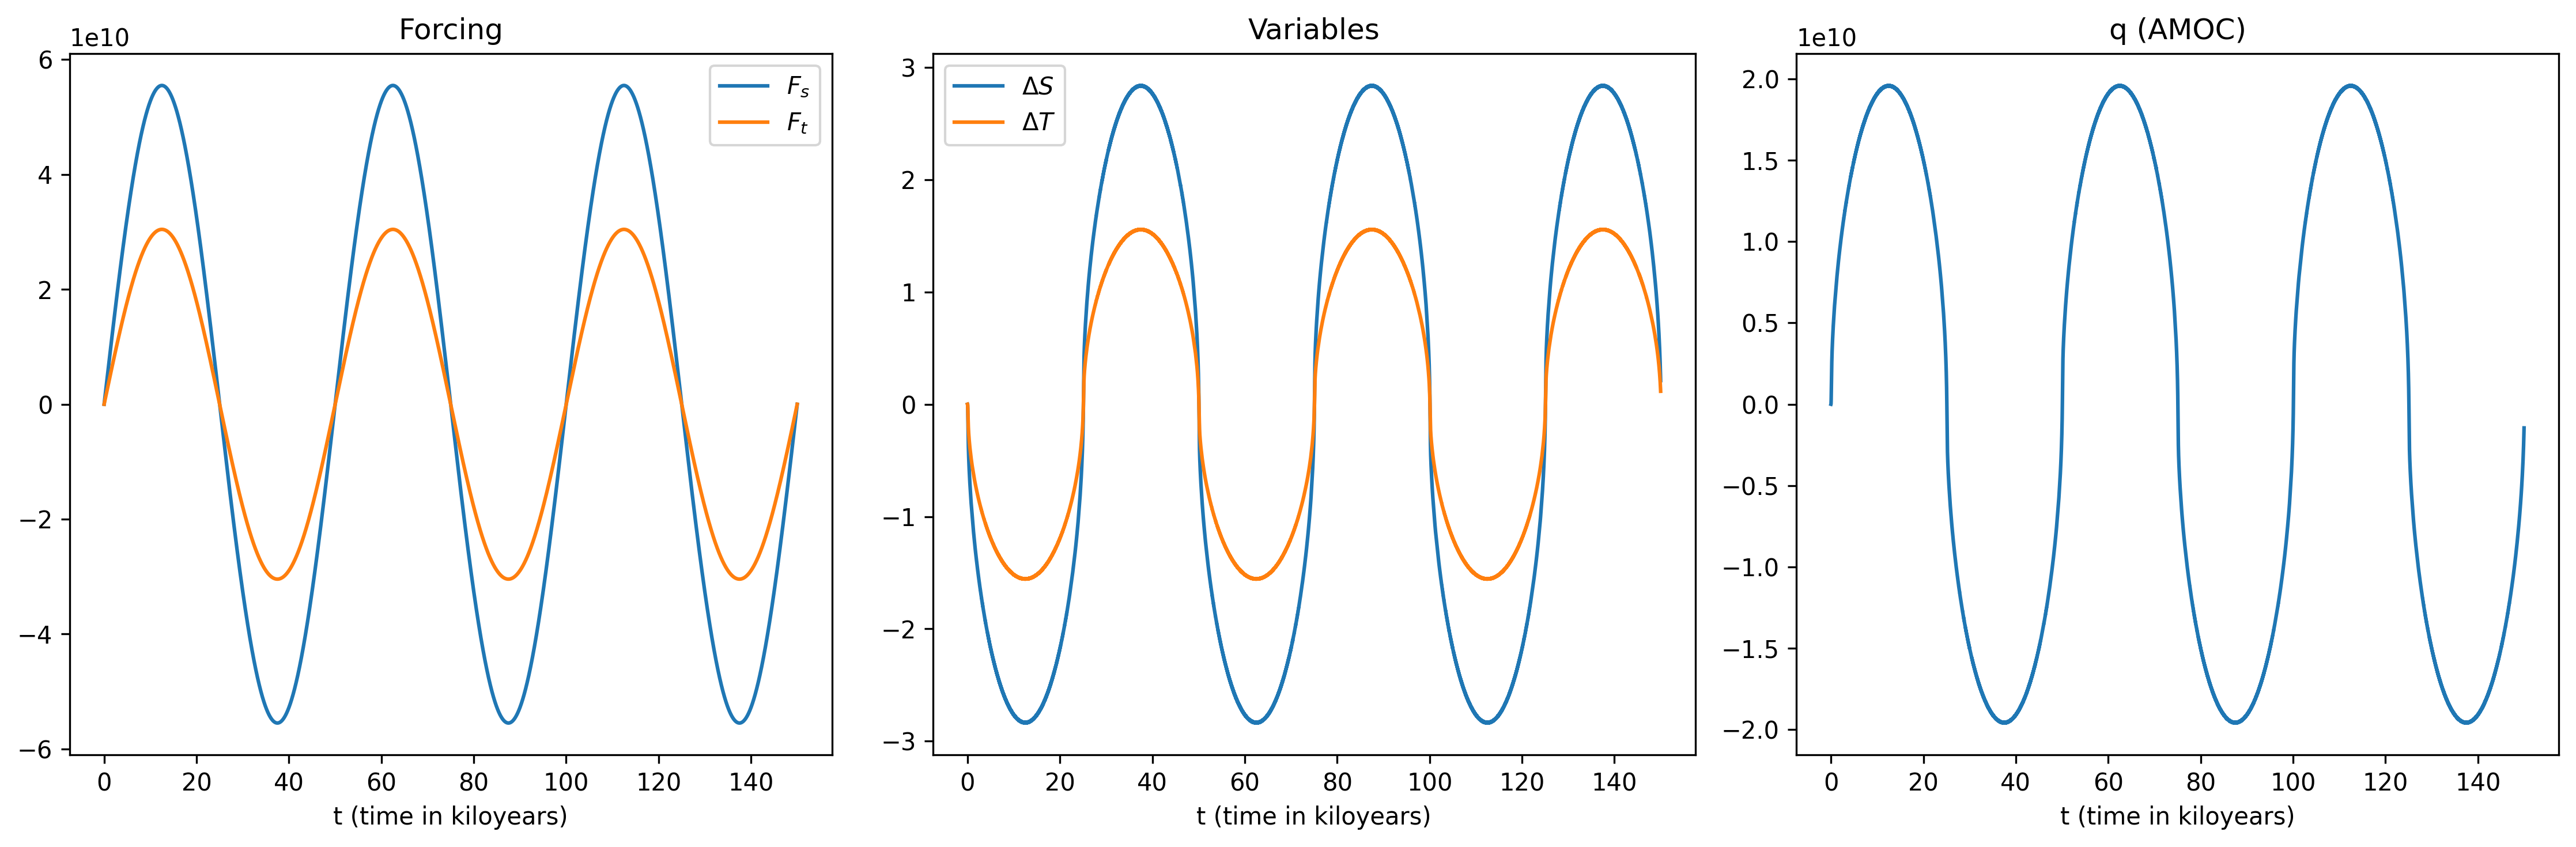

In [64]:
generate_plots("sine", True, True)